In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [84]:
def f(x):
    return 3*x**2 - 4*x + 5 # Some random function to understand stuff

In [85]:
f(3.0)

20.0

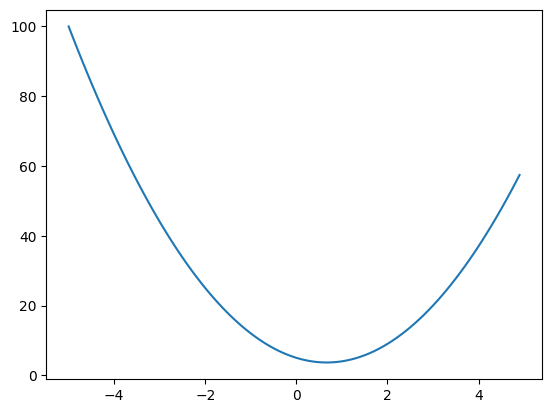

In [86]:
xs = np.arange(-5, 5, 0.1)
ys = f(xs)
plt.plot(xs, ys)

In [87]:
a= 3.0
b = -2.0
c = 10.0
d = a*b + c
print(d)

4.0


In [88]:
h = 0.0001

a = 3.0
b = -2.0
c = 10.0

d1 = a*b + c
a+=h
d2 = a*b + c

print((d2-d1)/h) # derivative of d wrt a

-2.0000000000042206


In [89]:
class Value:
    
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.grad = 0.0
        self.label = label

    def __repr__(self):
        return f"Value(date={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out 
    
    def __radd__(self, other): # other + self
        return self + other
    
    def __neg__(self):
        return self * -1.0
    
    def __sub__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + (-other.data), (self, other), '-')
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += -1.0 * out.grad
        out._backward = _backward
        return out
    
    def __rsub__(self, other): # other - self
        return self.__neg__() + other
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    
    def __rmul__(self, other): # other * self
        return self * other
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "Other must be int, float or Value"
        out = Value(self.data**other, (self,), '**')
        def _backward():
            self.grad += other * self.data**(other - 1) * out.grad
        out._backward = _backward
        return out
    
    def __truediv__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data / other.data, (self, other), '/')
        def _backward():
            self.grad += 1.0 / other.data * out.grad
            other.grad += -self.data / other.data**2 * out.grad
        out._backward = _backward
        return out

    def exp(self):
        out = Value(math.exp(self.data), (self,), 'exp')
        def _backward():
            self.grad += math.exp(self.data) * out.grad
        out._backward = _backward
        return out

    def tanh(self):
        out = Value(math.tanh(self.data), (self,), 'tanh')
        def _backward():
            self.grad = (1.0 - out.data**2) * out.grad
        out._backward = _backward
        return out
    
    def backward(self):
        self.grad = 1.0
        visited = set()
        def _backward(v):
            if v not in visited:
                visited.add(v)
                v._backward()
                for child in v._prev:
                    _backward(child)
        _backward(self) 

In [90]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [91]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

o.backward()

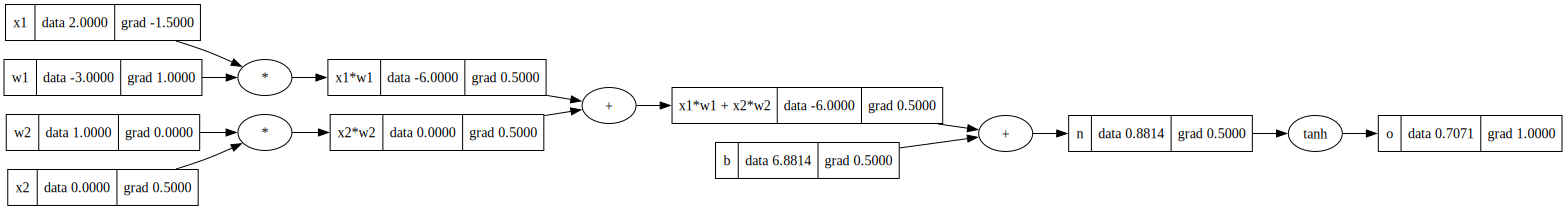

In [92]:
draw_dot(o)

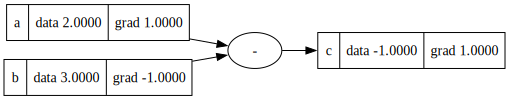

In [93]:
a = Value(2.0, label='a')
b = Value(3.0, label='b')

c = a - b; c.label = 'c'
c.backward()
draw_dot(c)

In [94]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = ((2*n).exp() - 1)/((2*n).exp() + 1); o.label = 'o'

o.backward()

In [95]:
import torch

In [96]:
import random

In [97]:
class Neuron:
  
  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))
  
  def __call__(self, x):
    # w * x + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out
  
  def parameters(self):
    return self.w + [self.b]

class Layer:
  
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]
  
  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs
  
  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
  
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x
  
  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

In [98]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [99]:
n = MLP(3, [4, 4, 1])

In [100]:
for k in range(20):
    # forward pass
    ypred = [n(x) for x in xs]
    # compute loss
    loss = sum(((yout - ygt)**2) for ygt, yout in zip(ys, ypred))
    # zero gradients
    for p in n.parameters():
        p.grad = 0.0
    # backward pass
    loss.backward()
    # optimisation
    for p in n.parameters():
        p.data += -0.1 * p.grad

    print(k, loss.data)

0 1.0297711423367135
1 0.23528920256440897
2 0.062861657481412
3 0.051632071967378554
4 0.044341920790948924
5 0.03729406474931567
6 0.03273704295559563
7 0.029904065922460633
8 0.027542878097840565
9 0.02505214488308042
10 0.022992133299008337
11 0.021534560130706384
12 0.020247796221534258
13 0.018836641864186415
14 0.01782700936817626
15 0.01694482256948988
16 0.016148721650277115
17 0.015269409762796955
18 0.014617919407610248
19 0.013869105708012416


In [101]:
ypred

[Value(date=0.9425810266867497),
 Value(date=-0.936049134601697),
 Value(date=-0.9566410155482028),
 Value(date=0.9321586225539191)]

In [102]:
n.parameters()

[Value(date=-0.5795030896754874),
 Value(date=-0.8084934654889512),
 Value(date=0.8151868987578091),
 Value(date=0.41973352084215415),
 Value(date=0.4445459157417048),
 Value(date=0.06154259945865657),
 Value(date=-0.5380535007701179),
 Value(date=0.43065717111753354),
 Value(date=-0.12682565597812562),
 Value(date=-0.7312963335137826),
 Value(date=0.9289514780212477),
 Value(date=0.4299648488337431),
 Value(date=1.043346225999247),
 Value(date=-0.4883867593240633),
 Value(date=-0.6390003539956246),
 Value(date=0.037666934947466556),
 Value(date=0.6031467110627955),
 Value(date=0.09696280349728398),
 Value(date=0.7723585889176531),
 Value(date=-0.3148392681868134),
 Value(date=0.11304900664709044),
 Value(date=0.8508721874502085),
 Value(date=-0.41060558840347194),
 Value(date=0.5976394769886757),
 Value(date=0.662722286613308),
 Value(date=-0.4123251642969434),
 Value(date=0.40654694077849785),
 Value(date=0.6118890746889288),
 Value(date=-1.1922612408515134),
 Value(date=0.6255773200

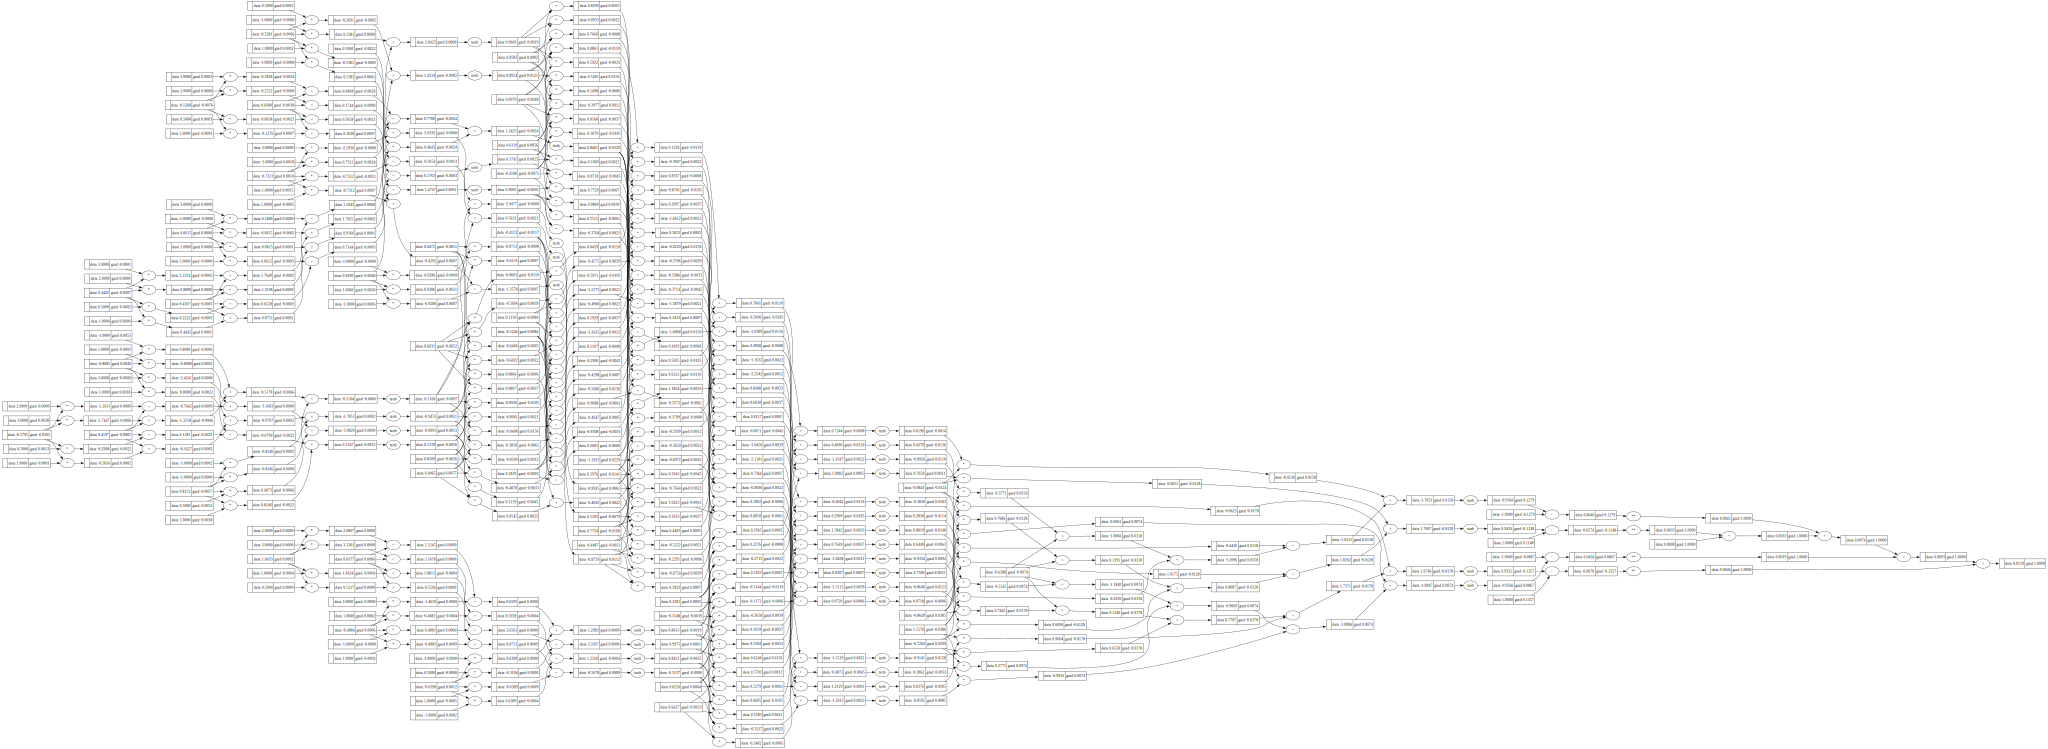

In [103]:
draw_dot(loss)